# Lab:  Source Localization for EEG

EEG or [Electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) is a powerful tool for neuroscientists in understanding brain activity.  In EEG, a patient wears a headset with electrodes that measures voltages at a number of points on the scalp.  These voltages arise from ionic currents within the brain.  A common *inverse problem* is to estimate the which parts of the brain caused the measured response.  Source localization is useful in understanding which parts of the brain are involved in certain tasks.  A key challenge in this inverse problem is that the number of unknowns (possible locations in the brain) is much larger than the number of measurements.  In this lab, we will use LASSO regression on a real EEG dataset to overcome this problem and determine the brain region that is active under an auditory stimulus.

In addition to the concepts in the [prostate LASSO demo](./demo_prostate.ipynb) you will learn to:
* Represent responses of multi-channel time-series data, such as EEG, using linear models
* Perform LASSO and Ridge regression
* Select the regularization level via cross-validation
* Visually compare the sparsity between the solutions

We first download standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). The sample data is a recording from one subject who experienced some auditory stimulus on the left ear.    

The raw data is very large (`1.5G`) and also requires that you install the `mne` python package. To make this lab easier, I have extracted and processed a small section of the data.  The following commands will get the data from a `pickle` file `eeg_dat.p` stored remotely.

In [2]:
import cloudpickle
from urllib.request import urlopen
with urlopen("http://www.ece.ohio-state.edu/~schniter/nonpublic/eeg_dat.p") as fp:
    [X,Y] = cloudpickle.load(fp)

To understand the data, there are three key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Current is measured at each brain region (called a *voxel*) in three separate directions: `x`, `y`, and `z`.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices are:
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.

Using `X.shape` and `Y.shape` compute and print `nt`, `nchan`, `ncur` and `nvoxels`.

In [3]:
# TODO
# nt = ...
# ncur = ...
# nchan = ...
# nvoxels
nchan, ncur = X.shape
nchan, nt = Y.shape
nvoxels = ncur // 3
print('Number times   = %d' % nt)
print('Number currents = %d' % ncur)
print('Number voxels = %d' % nvoxels)
print('Number channels = %d' % nchan)

Number times   = 85
Number currents = 22494
Number voxels = 7498
Number channels = 305


## The need for Regularization

Our goal is to estimate the currents `W` in the brain from the measurements `Y`.  We will use the linear model

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and where `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

Note that this model differs slightly from the linear regression model that we considered in most of the lectures, in the following sense. At sample index `i`, the target is a *vector* `Y[i,:]` (not a scalar `y[i]`). Thus, the regresson coefficients `W[j,:]` must also be *vectors* (rather than a scalars `w[j]`) and the bias `b[:]` must also be a *vector* (rather than a scalar `b`).  In other words, if we considered only a *single* value of `k` in the above model, then we would get a scalar-target model that takes the form `y[i] = \sum_j X[i,j]*w[j] + b`.  But in this lab, we have several values of `k`.

However, there is a major problem:
*  There are `nt` times `ncur` unknowns in `W`
*  There are `nt` time `nchan` measurements in `Y`
*  `ncur` is much larger than `nchan`

In other words, we have

    number of unknowns >> number of measurements
    
In this case, the least-squares solution is not unique (and the matrix we'd like to invert when computing the least-squares solution is not invertible).  We can remedy this problem using regularization.  We first try Ridge regression, and later LASSO.

## Ridge Regression

First split the data into training and test.  Use the `train_test_split` function with `test_size=0.33`.

In [4]:
# TODO
# Xtr,Xts,Ytr,Yts = train_test_split(...) 
Xtr,Xts,Ytr,Yts = train_test_split(X,Y,test_size=0.33)

Use the `Ridge` regression object in `sklearn` to fit the model on the training data.  Start with a regularization weight of `alpha=1` and see how well this works.

In [5]:
regr = Ridge(alpha=1)
regr.fit(Xtr,Ytr)

Ridge(alpha=1)

Predict the values `Y` on both the training and test data.  Use the `r2_score` method to measure the `R^2` value on both the training and test.  You will see that `R^2` value is large for the training data, while it is very low for the test data.  This suggest that, with regularization weight `alpha=1`, the model is over-fitting the data.

In [6]:
# TODO
# rsq_tr = ...
# rsq_ts = ...
Yhat = regr.predict(Xtr)
rsq_tr = r2_score(Ytr, Yhat)
print('R^2 training = %7.4f' % rsq_tr)


Yhat = regr.predict(Xts)
rsq_ts = r2_score(Yts, Yhat)
print('R^2 test     = %7.4f' % rsq_ts)


R^2 training =  0.5830
R^2 test     =  0.1679


Next, try to see if we can get a better `R^2` score using a different value of `alpha`.  In particular, use cross-validation to measure the test `R^2` for 20 `alpha` values logarithmically spaced from `10^{-2}` to `10^{2}` (use `np.logspace()`).  You can use cross-validation on the train/test split from above.  You do not need to do `K`-fold.

In [7]:
# TODO
alphas = np.logspace(-2,2,20)
rsq = []

for a in alphas:
    regr = Ridge(alpha=a)
    regr.fit(Xtr,Ytr)
    
    Yhat = regr.predict(Xts)
    rsqi = r2_score(Yts, Yhat)
    rsq.append(rsqi)
    
    print('alpha=%12.4e rsq=%7.4f' % (a,rsqi))

alpha=  1.0000e-02 rsq=-0.2106
alpha=  1.6238e-02 rsq=-0.1210
alpha=  2.6367e-02 rsq=-0.0411
alpha=  4.2813e-02 rsq= 0.0305
alpha=  6.9519e-02 rsq= 0.0936
alpha=  1.1288e-01 rsq= 0.1453
alpha=  1.8330e-01 rsq= 0.1814
alpha=  2.9764e-01 rsq= 0.1987
alpha=  4.8329e-01 rsq= 0.1971
alpha=  7.8476e-01 rsq= 0.1803
alpha=  1.2743e+00 rsq= 0.1538
alpha=  2.0691e+00 rsq= 0.1230
alpha=  3.3598e+00 rsq= 0.0918
alpha=  5.4556e+00 rsq= 0.0634
alpha=  8.8587e+00 rsq= 0.0397
alpha=  1.4384e+01 rsq= 0.0212
alpha=  2.3357e+01 rsq= 0.0076
alpha=  3.7927e+01 rsq=-0.0020
alpha=  6.1585e+01 rsq=-0.0086
alpha=  1.0000e+02 rsq=-0.0129


Plot the test `R^2` vs. `alpha`.  And print the maximum test `R^2`.  You should see that the maximum test `R^2` is better, but still not very high.

Optimal R^2 =  0.1987


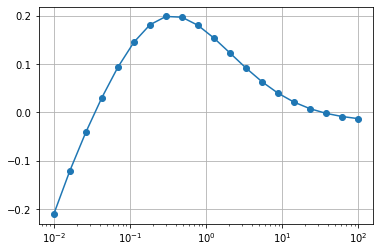

In [8]:
rsq = np.array(rsq)
plt.semilogx(alphas, rsq, 'o-')
plt.grid()

rsq_opt = np.max(rsq)
print('Optimal R^2 = %7.4f' % rsq_opt)

Now, let's take a closer look at the solution. 

* Find the optimal regularization `alpha` from the above cross-validation
* Re-fit the model using the training data and the optimal `alpha` 
* Extract the matrix `W` of linear model coefficients.  These are stored as `regr.coef_` in transposed form, so apply a transpose to get W as we defined it above
* For each current `j` compute `Wrms[j] =  sqrt( sum_k W[j,k]**2 )`, which is the root mean squared value across time.
* Finally, plot the `Wrms` vector.

You will see that the RMS current vector `Wrms` is not sparse.  This means that the solution found by Ridge regression allows non-zero currents in all locations.

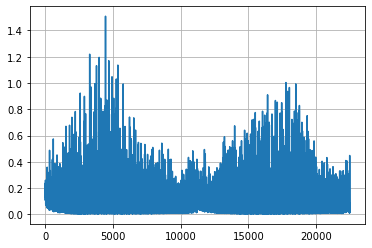

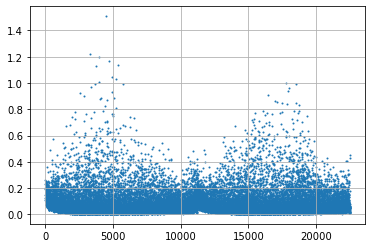

In [9]:
im = np.argmax(rsq)
aopt = alphas[im]

regr = Ridge(alpha=aopt)
regr.fit(Xtr,Ytr)

W = regr.coef_.T
Wrms = np.sqrt(np.sum(W**2, axis=1))

# regular plot
plt.plot(Wrms)
plt.grid()

# scatter plot... another option
plt.figure()
plt.scatter(np.arange(ncur),Wrms,s=1) 
plt.grid()

## LASSO Regression

We can improve the estimate by rewarding sparsity.  Biologically, we know that only a limited number of brain regions should be involved in the response to a particular stimuli.  As a result, we expect that the current matrix `W[j,k]` should be zero-valued for most locations `j` at each time `k`.  We can impose this constraint using LASSO regularization with an appropriate strength `alpha`.

Re-fit the training data using the `Lasso` model with `alpha=1e-4`.  Also set `max_iter=100` and `tol=0.01`.  The LASSO solver is much slower than Ridge regression, so this may take a minute.

In [10]:
# TODO
regr = Lasso(alpha = 1e-4,max_iter=100,tol=0.01)
regr.fit(Xtr,Ytr)

Lasso(alpha=0.0001, max_iter=100, tol=0.01)

Next, evaluate the model on the test data and measure the `R^2` value.  You should get a better fit than you did with Ridge regression.  

In [11]:
# TODO
Yhat = regr.predict(Xts)
rsq = r2_score(Yts, Yhat)
print(rsq)

0.3180296038725383


Still, the value `alpha=1e-4` was only a guess.  We should do even better with the optimal `alpha`. 

Use cross-validation (with the above test/train split) to evaluate different values of `alpha` logarithically spaced between `alpha=1e-4` and `alpha=1e-3`.  Computing each fit may take some time, so use only 5 values of `alpha`. Also, for each `alpha` you try, store the weight matrix.  This way, you will not have to re-fit the model if you want to examine the weights.

In [12]:
alphas = np.logspace(-4,-3,5)
rsq = []
Ws = []

for a in alphas:
    
    # Fit the model
    regr = Lasso(alpha =a, max_iter=100, tol=0.01)
    regr.fit(Xtr,Ytr)
    
    # Predict 
    Yhat = regr.predict(Xts)
    
    # Score
    rsqi = r2_score(Yts, Yhat)
    rsq.append(rsqi)
    
    # Save the current matrix
    Ws.append(regr.coef_.T)
    
    
    # Print results
    print('alpha = %12.4e rsq=%7.4f' % (a, rsqi))

alpha =   1.0000e-04 rsq= 0.3180
alpha =   1.7783e-04 rsq= 0.3358
alpha =   3.1623e-04 rsq= 0.3085
alpha =   5.6234e-04 rsq= 0.2326
alpha =   1.0000e-03 rsq= 0.1453


Plot the `R^2` value vs. `alpha`.  Print the optimal `R^2`.  You should see it is higher than with the best Ridge Regression case.

Optimal test R^2 =  0.3358


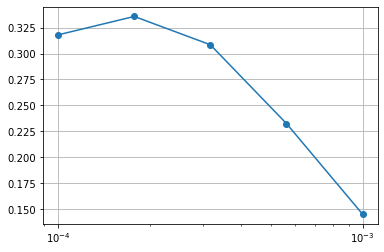

In [13]:
rsq = np.array(rsq)
plt.semilogx(alphas, rsq, 'o-')
plt.grid()

rsq_opt = np.max(rsq)
print('Optimal test R^2 = %7.4f' % rsq_opt)

Display the RMS current values `Wrms` for the optimal `alpha`, as you did in the Ridge Regression case.  You will see that is much sparser.

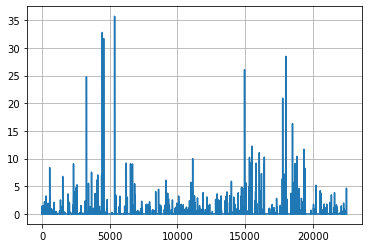

In [14]:
iopt = np.argmax(rsq)
Wopt = Ws[iopt]
Wrms = np.sqrt(np.sum(Wopt**2, axis=1))

plt.plot(Wrms)
plt.grid()

## More fun

If you want to dive deeper into this application:
* Install the [MNE python package](https://martinos.org/mne/stable/index.html).  This is an amazing package with many tools for processing EEG data.
* In particular, you can use the above to visualize where in the brain the currents are active.
* You can also improve the fitting with better regularization.  For example, you could experiment with the combination of LASSO and ridge regression, known as ElasticNet.  There is a regression object for this in sklearn.linear_model.
* We could also use a more sophisticated regularization technique called Group LASSO, that encourages *entire rows* of the `W` matrix to be zero-valued.  This is appropriate in this application because, if the current is zero for one time, it is likely to be zero for all time. 
* You can even use the recovered current patterns to make predictions about what the patient is seeing or hearing or thinking!  It sounds like science-fiction, but it has been demonstrated to work to a certain extent!